# License

    Jupyter notebook for accessing CUDA
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

from matplotlib import pyplot as plt

In [2]:
#Initialize CUDA - must be first call to CUDA!
cuda_driver.init()

In [3]:
#Create CUDA context
cuda_device = cuda_driver.Device(0)
print("Using '{:s}'".format(cuda_device.name()))
print(" => compute capability: {:s}".format(str(cuda_device.compute_capability())))
context = cuda_device.make_context()
free, total = cuda_driver.mem_get_info()
print(" => memory: {:d} / {:d} MB available".format(int(free/(1024*1024)), int(total/(1024*1024))))

Using 'Tesla K80'
 => compute capability: (3, 7)
 => memory: 11128 / 11441 MB available


In [10]:
cuda_kernel = """
__global__ void addVectorKernel(float* c, float* a, float* b) {
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    c[i] = a[i] + b[i];
}

__global__ void addMatrixKernel(float* c, float* a, float* b, int cols){
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    unsigned int j = blockIdx.y*blockDim.y + threadIdx.y;
    
    // Some pseudo-code..
    // c[j,i] = a[j,i] + b[j,i]
    unsigned int k = j*cols + i; // linear index
    
    c[k] = a[k] + b[k];
}
"""
module = cuda_compiler.SourceModule(cuda_kernel)
# kernel = module.get_function("addVectorKernel");
kernel = module.get_function("addMatrixKernel");
print("Seems fine\n")


Seems fine



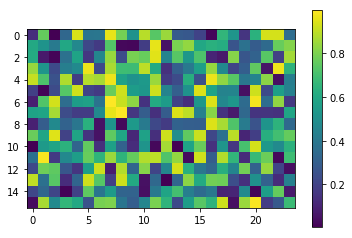

In [16]:
# THe one here is just CPU code..
#Size of our test
# test_size = (64, 128)
test_size = (16, 24)
# n = 50

#Create test input / output data
a = np.random.random(test_size).astype(np.float32)
b = np.random.random(test_size).astype(np.float32)
c = np.empty_like(a)

# fig = plt.figure(figsize=(12,8))
fig = plt.figure()
plt.imshow(a)
plt.colorbar()
fig.show()

In [42]:
print(a.shape) # let's check what I'll send to the GPU... 

(16, 24)


In [43]:
#Upload data to the device
a_g = GPUArray(a.shape, np.float32) # create the variable
b_g = GPUArray(b.shape, np.float32) # create the variable
a_g.set(a) # put the value (import from CPU to GPU)
b_g.set(b) # put the value (import from CPU to GPU)

In [44]:
#Allocate output data
c_g = GPUArray(c.shape, np.float32)
print(c_g.shape) # test..

(16, 24)


In [50]:
# Let's create a couple of variables..
# a.shape is [rows, columns] => [y, x]
domain_size = (a.shape[1], a.shape[0]) # now the domain_size is [x,y]
block_size = (8, 8, 1)
# double shash // : integer division 
grid_size = (domain_size[0]//block_size[0], domain_size[1]//block_size[1], 1)
print("Domain size is " + str(domain_size))
print("Block size is " + str(block_size))
print("Grid size is " + str(grid_size))

Domain size is (24, 16)
Block size is (8, 8, 1)
Grid size is (3, 2, 1)


In [51]:
#Execute program on device
# ATTENTION! SPECIFY int32!!!
kernel(c_g, a_g, b_g, np.int32(domain_size[0]), block=block_size, grid=grid_size)

#Copy data from device to host
c_g.get(c)

array([[0.64903545, 1.230728  , 0.999541  , 0.38165197, 0.9421215 ,
        0.7671041 , 0.59637123, 1.9304624 , 1.6516126 , 0.84641343,
        1.070289  , 0.8194755 , 1.1059933 , 0.41026598, 0.63783294,
        1.1175535 , 0.3007932 , 1.0978124 , 1.3216419 , 0.20970058,
        0.94793326, 0.994747  , 1.0003256 , 0.75274557],
       [0.6169826 , 0.72902966, 0.6410567 , 0.7288935 , 1.0256281 ,
        0.44694322, 0.5314001 , 1.6116141 , 0.9948738 , 0.06941083,
        1.0018632 , 0.9912374 , 0.73478556, 0.95129085, 1.5516837 ,
        1.3881227 , 0.7773155 , 1.4414071 , 0.76839435, 0.711999  ,
        0.7058031 , 0.40912786, 0.8755916 , 1.6141733 ],
       [1.4371305 , 0.48609394, 0.47277448, 1.2137411 , 1.1776917 ,
        1.1323987 , 1.1773882 , 1.2899029 , 1.1613115 , 1.5542676 ,
        1.1413835 , 1.6895493 , 1.3364164 , 0.8810821 , 1.1483275 ,
        1.2981863 , 1.0397979 , 0.67039144, 1.4319398 , 0.83830404,
        1.0011518 , 1.3295101 , 0.5010029 , 1.7413459 ],
       [1.479

In [52]:
#Compute reference using Numpy
c_ref = a + b

#Print result
print("C   = ", c)
print("Ref = ", c_ref)
print("Sad = ", np.sum(np.abs(c - c_ref)))

C   =  [[0.64903545 1.230728   0.999541   0.38165197 0.9421215  0.7671041
  0.59637123 1.9304624  1.6516126  0.84641343 1.070289   0.8194755
  1.1059933  0.41026598 0.63783294 1.1175535  0.3007932  1.0978124
  1.3216419  0.20970058 0.94793326 0.994747   1.0003256  0.75274557]
 [0.6169826  0.72902966 0.6410567  0.7288935  1.0256281  0.44694322
  0.5314001  1.6116141  0.9948738  0.06941083 1.0018632  0.9912374
  0.73478556 0.95129085 1.5516837  1.3881227  0.7773155  1.4414071
  0.76839435 0.711999   0.7058031  0.40912786 0.8755916  1.6141733 ]
 [1.4371305  0.48609394 0.47277448 1.2137411  1.1776917  1.1323987
  1.1773882  1.2899029  1.1613115  1.5542676  1.1413835  1.6895493
  1.3364164  0.8810821  1.1483275  1.2981863  1.0397979  0.67039144
  1.4319398  0.83830404 1.0011518  1.3295101  0.5010029  1.7413459 ]
 [1.4799483  1.442204   1.2002741  0.92698747 0.6832366  1.7707378
  1.0460262  1.408762   1.1381397  1.5965083  1.8302593  0.8925898
  0.6166368  0.99991107 0.8908415  1.4960546  1

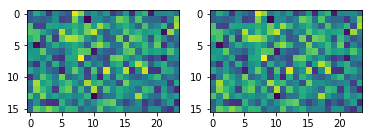

In [53]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(c)
plt.subplot(1,2,2)
plt.imshow(c_ref)
#plt.plot(c, '+r')
#plt.plot(c_ref, 'xb')